# Model Prototyping

## Imports

In [1]:
# Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import os
from tqdm import tqdm

# PyTorch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

# Transformers
from transformers import AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from transformers import AutoModelForSequenceClassification

# Hyperparameters optimization
import optuna
import wandb
import joblib

In [ ]:
# Google drive files for data
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# GPU used 
!nvidia-smi

Sun Dec 11 15:29:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.77       Driver Version: 512.77       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   41C    P8     3W /  N/A |      0MiB /  6144MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Prototyping using huggingface transformers

In [3]:
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False, normalization=True)

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
# INPUT TWEET IS ALREADY NORMALIZED!
line = "SC has first two presumptive cases of coronavirus , DHEC confirms HTTPURL via @USER :cry:"

input_ids = torch.tensor([tokenizer(line, padding="max_length", max_length=64, truncation=True).input_ids])


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Let's check for how many tokens we'll need

In [4]:
data = pd.read_csv("./train.csv")

In [ ]:
max = 0 
for text in data['text']:
  input_ids = tokenizer(text).input_ids
  max = np.max((max, len(input_ids)))

In [ ]:
print(max)

We can see the maximum number of tokens is 64, to take into account the fact that tweets from the test set may be longer, we'll set the max number of tokens to 90, this will speed the training.

In [ ]:
output = tokenizer.encode(line)
print(output)

In [ ]:
output_dict = tokenizer.encode_plus(line, add_special_tokens=True, max_length=90, padding='max_length', return_attention_mask=True, return_tensors='pt')
input_ids = output_dict.input_ids
attention_mask = output_dict.attention_mask

In [ ]:
input_ids

In [ ]:
attention_mask

## Data prep

We can use this pre-processing pipeline to clean and prepare the tweets before tokenizing them.

In [ ]:
import html
import re

# define clean function
# add / remove any line if necessary
def clean(text):
    # convert html escapes like &amp; by their plain-text representation
    text = html.unescape(text) 
    
    # subsitute tags like <tab> by spaces in the specified text or remove them
    text = re.sub(r'<[^<>]*>', ' ', text)
    
    # subsitute markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    
    # subsitute text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    
    # subsitute standalone sequences of specials, matches &# but NOT #hashtag
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)

     # subsitute standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    
    #remove stock market tickers like $GE
    text = re.sub(r'\$\w*', '', text)  
    
    #remove old style retweet text "RT"
    text = re.sub(r'RT[\s]+', '', text)        
    text = re.sub(r'DT[\s]+', '', text)   
    
    #remove hashtags
    text = re.sub(r'#', '', text)
    
    return text.strip()

In [ ]:
from textacy import preprocessing
from functools import partial

# create cleaning pipeline
preproc = preprocessing.make_pipeline(
    
    # join words split by a hyphen or line break
    preprocessing.normalize.hyphenated_words,
    
    # subsitute fancy quatation marks with an ASCII equivalent
    preprocessing.normalize.quotation_marks,
    
    # normalize unicode characters in text into canonical forms
    preprocessing.normalize.unicode,
    
    # remove any accents character in text by replacing them with ASCII equivalents or removing them entirely
    preprocessing.remove.accents,

    # remove all email addresses in text 
    partial(preprocessing.replace.emails, repl= ""), # or _EMAIL_
    
    # remove all phone numbers in text 
    partial(preprocessing.replace.phone_numbers, repl=""), # or _PhoneNumber_
    
    # remove all URLs in text 
    partial(preprocessing.replace.urls, repl= ""), # or _URL_
    
    # remove all (Twitter-style) user handles in text 
    partial(preprocessing.replace.user_handles, repl=""), # or _HANDLE_
    
    # Replace all hashtags in text with repl.
    #partial(preprocessing.replace.hashtags, repl="_HASTAG_"),
    
    ### TEST ### Enable it only before generating tokens for word clouds
    partial(preprocessing.replace.numbers, repl=""),
    
    # remove HTML tags from text
    preprocessing.remove.html_tags,

    # remove text within curly {}, square [], and/or round () brackets
    preprocessing.remove.brackets,

    # replace specific set of punctuation marks with whitespace
    partial(preprocessing.remove.punctuation, only=[ ",", ":", ";", "/", " ","(","@"]),
    
    # Replace all currency symbols in text with repl
    preprocessing.replace.currency_symbols,
    
    # replace all emoji and pictographs in text with repl.
    preprocessing.replace.emojis,
    
 )

In [ ]:
# Preprocessing
data['text_c'] = data['text'].apply(clean)
data['text_clean'] = data['text_c'].apply(preproc)
data['text_clean'] = data['text_clean'].str.lower()

In [5]:
# Tokenization
input_ids = []
attention_masks = []

tweets = data['text'].to_list()

for tweet in tweets:
  output_dict = tokenizer.encode_plus(tweet, add_special_tokens=True, max_length=90, padding='max_length', return_attention_mask=True, return_tensors='pt')
  input_ids.append(output_dict.input_ids)
  attention_masks.append(output_dict.attention_mask)

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

labels = torch.tensor(data['target'].values)

In [6]:
# Creating the dataset
from torch.utils.data import TensorDataset, random_split, DataLoader

dataset = TensorDataset(input_ids, attention_masks, labels)

In [7]:
# Splitting the dataset between training and validation

train_size = int(0.85 * len(dataset)) # 85 - 15 % split
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 32 # Bigger values will increase the gradient precision, lower values will reduce the memory load

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)

Once we found the best hyper-parameters, it's good to train the model on all the available data.

In [7]:
# Training on all samples
batch_size = 32
train_dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

## Hyperparameters optimization

This part is for the optimization of the hyper-parameters of BERT, powered by Optuna

In [19]:
# define model inside this function, the archicture can be optimized with optuna
def define_model(trial):

    model = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels = 2, output_attentions = False, output_hidden_states = False)  
    
    return model

In [20]:
def train_model_optuna(model, optimizer, scheduler, train_dataloader, trial, device = 'cpu', val_dataloader = None, epochs = 10):
  pbar = tqdm(range(epochs))

  metrics = {
    "epochs" : [],
    "train_losses" : [],
    "val_losses" : [],
    "val_accs" : [],
    "lr" : [],
  }

  for i, epoch in enumerate(pbar):
    model.train()

    total_train_loss = 0
    for i, batch in enumerate(train_dataloader):

      input_ids = batch[0].to(device)
      input_masks = batch[1].to(device)
      labels = batch[2].to(device)

      model.zero_grad()

      result = model(input_ids, token_type_ids = None, attention_mask = input_masks, labels = labels, return_dict = True)

      loss = result.loss
      logits = result.logits

      total_train_loss += loss.item()

      loss.backward()

      optimizer.step()

      # Call to scheduler only if it's linear
      scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    total_val_acc = 0
    total_val_loss = 0
    
    if val_dataloader is not None:

      model.eval()
      for i, batch in enumerate(val_dataloader):

        input_ids = batch[0].to(device)
        input_masks = batch[1].to(device)
        labels = batch[2].to(device)

        with torch.no_grad():

          result = model(input_ids, token_type_ids = None, attention_mask = input_masks, labels = labels, return_dict = True)

        loss = result.loss
        logits = result.logits.detach().cpu().numpy()
        labels = labels.cpu().numpy()

        preds = np.argmax(logits, axis = 1).flatten()
        labels = labels.flatten()

        val_acc = np.sum(preds == labels) / len(labels)

        total_val_acc += val_acc
        total_val_loss += loss.item()
    
      avg_val_loss = total_val_loss / len(val_dataloader)
      avg_val_acc = total_val_acc / len(val_dataloader)

    metrics['lr'].append(optimizer.param_groups[0]['lr'])

    # Call to scheduler only if it's reduce on plateau
    # scheduler.step(avg_val_loss)

    metrics['epochs'].append(epoch)
    metrics['train_losses'].append(avg_train_loss)

    if val_dataloader is not None :
      metrics['val_losses'].append(avg_val_loss)
      metrics['val_accs'].append(avg_val_acc)
      pbar.set_postfix({'train_loss': avg_train_loss, 'val_loss': avg_val_loss, 'val_acc' : avg_val_acc})

    if trial is not None:
      trial.report(avg_val_loss, epoch)

      # Report metrics to wandb
      wandb.log(data = {
          'train_loss' : metrics['train_losses'][-1],
          'val_loss' : metrics['val_losses'][-1],
          'val_acc' : metrics['val_accs'][-1],
          'lr' : metrics['lr'][-1]
      }, step = epoch)

      if trial.should_prune():
        wandb.run.summary['state'] = "pruned"
        wandb.finish(quiet = True)
        raise optuna.exceptions.TrialPruned()

    if (epoch + 1) % 10 == 0:
      # Saving the fine tunned model
      ckpt = {
          'epoch' : epoch,
          'model_state' : model.state_dict(),
          'optimizer_state' : optimizer.state_dict()
      }

  return model, metrics

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device : {device}")

def objective(trial):
  
    # Generate the model
    model = define_model(trial).to(device) 

    # Define learning components (to be used in learning function)
    lr = trial.suggest_float("lr", 1e-8, 5e-5)

    optimizer = torch.optim.AdamW(model.parameters(), lr = lr, betas = (0.9, 0.999), eps = 1e-8)

    epochs = trial.suggest_int("epoch", 1, 5)

    total_steps = len(train_dataloader) * epochs

    num_warmup_steps = trial.suggest_int("warmup_steps", 0, int(0.1 * total_steps))

    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = num_warmup_steps, num_training_steps = total_steps)
    
    # init tracking with wandb
    config = dict(trial.params)
    config['trial.number'] = trial.number
    wandb.init(
        project="twitter_disaster_tweets",
        entity="saulofein",
        config=config,
        group=tag,
        reinit=True        
    )
    
    # Learning
    model, metrics = train_model_optuna(model, optimizer, scheduler, train_dataloader, trial, val_dataloader = val_dataloader, device = device, epochs = epochs)
    
    # Compute the metrics Optuna will try to otpimize (maximize or minimize)
    val_loss = metrics['val_losses'][-1]
    
    # Report the RMSE to wandb
    wandb.run.summary['val_loss'] = val_loss
    wandb.run.summary['state'] = 'completed'
    wandb.finish(quiet = True)
    
    return val_loss

Using device : cuda


In [ ]:
tag = 'bert_1'

study = optuna.create_study(direction = "minimize", study_name = tag)
study.optimize(objective, n_trials = 100)

# Best parameters
print("Best trial :")
best_trial = study.best_trial
print("  Value :", best_trial.value)
print("  Params:")
for key, value in best_trial.params.items():
    print(f"    {key} : {value}")

# Importance of hyper-parameters
importance_dict = optuna.importance.get_param_importances(study = study)
plt.figure(figsize = (20, 15))
sns.barplot(x = list(importance_dict.values()), y = list(importance_dict.keys()))
plt.savefig(os.path.join("..", "hyperparameters_importance_{}.png".format(tag.split('_')[1])))

# Save best parameters dict
joblib.dump(best_trial.params, f"best_params_{tag}.pkl")

We ran two trials of 100 runs each and we found the following best hyper-parameters, what is inside the parenthesis is the objective used to conduct the optimization

Best trial (val loss) :
  * Value : 0.3834475175374084
  * Params:
    * lr : 3.588461431799714e-05
    * epoch : 1
    * warmup_steps : 8

Best trial (val accuracy) :
  * Value : 0.8525094696969697
  * Params:
    * lr : 2.913641013195014e-05
    * warmup_steps : 16
    * epoch : 1

Relative importance of hyperparameters :
* Number of epochs : 70%
* Learning rate : 30%

## Train model

Using best hyperparameters found, we only need to train it once more and use val data to set the classification threshold

In [8]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels = 2, output_attentions = False, output_hidden_states = False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device : {device}")

model.to(device)

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

Using device : cuda


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [9]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 2.914e-05, betas = (0.9, 0.999), eps = 1e-8)

In [10]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import get_linear_schedule_with_warmup

def train_model(model, optimizer, scheduler, train_dataloader, val_dataloader = None, epochs = 10):
  pbar = tqdm(range(epochs))

  metrics = {
    "epochs" : [],
    "train_losses" : [],
    "val_losses" : [],
    "val_accs" : [],
    "lr" : [],
  }

  for i, epoch in enumerate(pbar):
    model.train()

    total_train_loss = 0
    for i, batch in enumerate(train_dataloader):

      input_ids = batch[0].to(device)
      input_masks = batch[1].to(device)
      labels = batch[2].to(device)

      model.zero_grad()

      result = model(input_ids, token_type_ids = None, attention_mask = input_masks, labels = labels, return_dict = True)

      loss = result.loss
      logits = result.logits

      total_train_loss += loss.item()

      loss.backward()

      optimizer.step()

      # Call to scheduler only if it's linear
      scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    total_val_acc = 0
    total_val_loss = 0
    
    if val_dataloader is not None:

      model.eval()
      for i, batch in enumerate(val_dataloader):

        input_ids = batch[0].to(device)
        input_masks = batch[1].to(device)
        labels = batch[2].to(device)

        with torch.no_grad():

          result = model(input_ids, token_type_ids = None, attention_mask = input_masks, labels = labels, return_dict = True)

        loss = result.loss
        logits = result.logits.detach().cpu().numpy()
        labels = labels.cpu().numpy()

        preds = np.argmax(logits, axis = 1).flatten()
        labels = labels.flatten()

        val_acc = np.sum(preds == labels) / len(labels)

        total_val_acc += val_acc
        total_val_loss += loss.item()
    
      avg_val_loss = total_val_loss / len(val_dataloader)
      avg_val_acc = total_val_acc / len(val_dataloader)

    metrics['lr'].append(optimizer.param_groups[0]['lr'])

    # Call to scheduler only if it's reduce on plateau
    # scheduler.step(avg_val_loss)

    metrics['epochs'].append(epoch)
    metrics['train_losses'].append(avg_train_loss)

    if val_dataloader is not None :
      metrics['val_losses'].append(avg_val_loss)
      metrics['val_accs'].append(avg_val_acc)
      pbar.set_postfix({'train_loss': avg_train_loss, 'val_loss': avg_val_loss, 'val_acc' : avg_val_acc})

    if (epoch + 1) % 10 == 0:
      # Saving the fine tunned model
      ckpt = {
          'epoch' : epoch,
          'model_state' : model.state_dict(),
          'optimizer_state' : optimizer.state_dict()
      }
      torch.save(ckpt, "weights_bertweet_intermediate.pt")

  # Saving the fine tunned model
  ckpt = {
          'epoch' : epoch,
          'model_state' : model.state_dict(),
          'optimizer_state' : optimizer.state_dict()
      }
  torch.save(ckpt, "weights_bertweet_final.pt")

  return model, metrics

In [11]:
epochs = 1

total_steps = len(train_dataloader) * epochs

# scheduler = ReduceLROnPlateau(optimizer, mode = 'min', patience = 5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 16, num_training_steps = total_steps)

model, metrics = train_model(model, optimizer, scheduler, train_dataloader, epochs = epochs)

100%|██████████| 1/1 [07:58<00:00, 478.25s/it]


Text(0.5, 1.0, 'Learning rate')

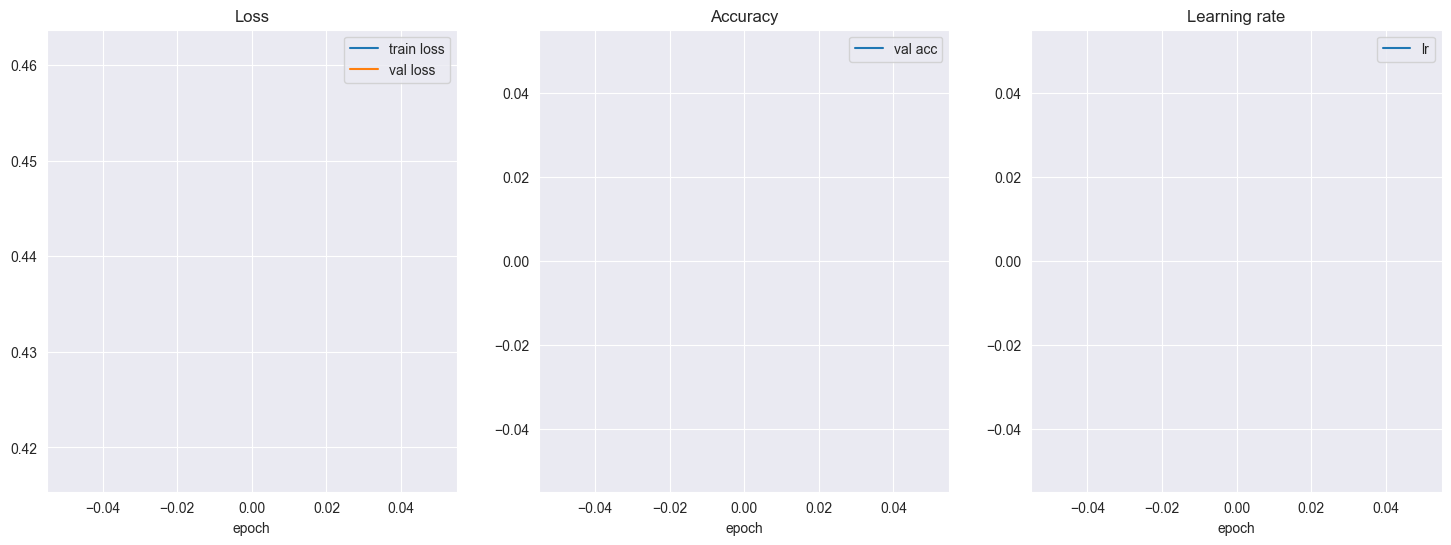

In [19]:
# Visualization of the metrics
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)

plt.plot(metrics['train_losses'], label='train loss')
plt.plot(metrics['val_losses'], label='val loss')
plt.xlabel("epoch")
plt.legend()
plt.title('Loss')

plt.subplot(1, 3, 2)
plt.plot(metrics['val_accs'], label='val acc')
plt.xlabel("epoch")
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 3, 3)
plt.plot(metrics['lr'], label='lr')
plt.xlabel("epoch")
plt.legend()
plt.title('Learning rate')

In [12]:
from sklearn.metrics import confusion_matrix

def get_preds(dataloader, model, threshold = 0.5, device = 'cpu'):
  
  all_labels = torch.tensor([])
  all_preds = torch.tensor([])

  model.eval()
  for i, batch in enumerate(dataloader):

      input_ids = batch[0].to(device)
      input_masks = batch[1].to(device)
      labels = batch[2].to(device)

      with torch.no_grad():
        result = model(input_ids, token_type_ids = None, attention_mask = input_masks, labels = labels, return_dict = True)

      loss = result.loss
      logits = result.logits.detach().cpu()
      labels = labels.cpu()

      preds = (logits[:, 1].cpu() >= threshold).type(dtype=torch.int32)
      labels = labels.flatten()

      all_labels = torch.cat((all_labels, labels), dim=0)
      all_preds = torch.cat((all_preds, preds), dim=0)

  return all_labels, all_preds

In [13]:
all_labels, all_preds = get_preds(val_dataloader, model, 0.5, device)
cm = confusion_matrix(all_labels, all_preds)

NameError: name 'val_dataloader' is not defined

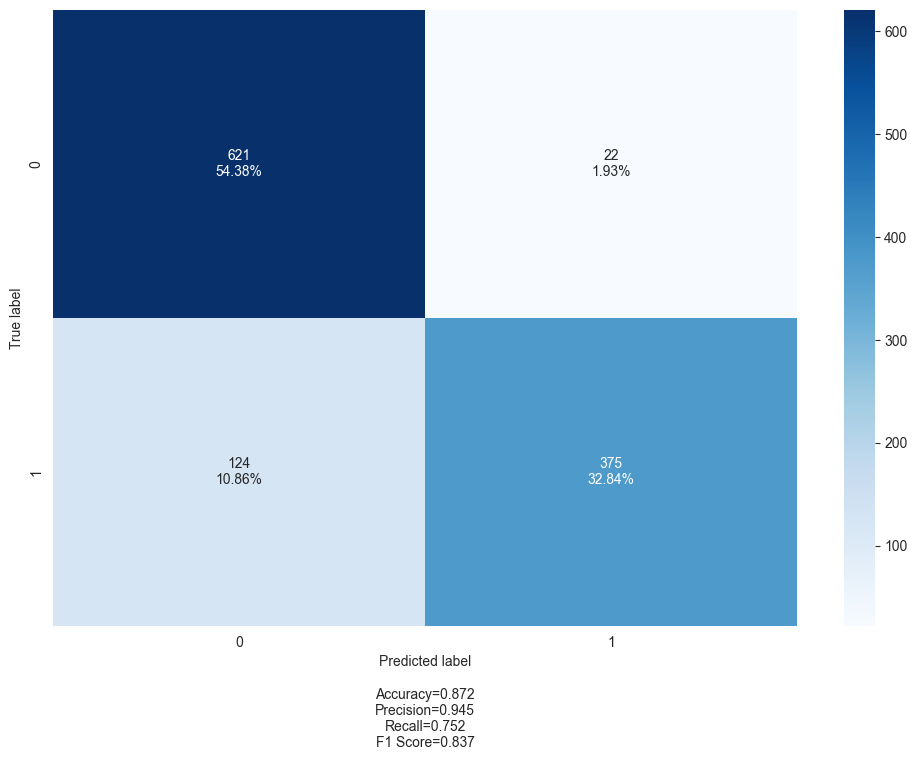

In [50]:
from utils import make_confusion_heatmap
make_confusion_heatmap(cm, figsize=(12,8))

In [51]:
from sklearn.metrics import roc_auc_score
roc_auc_score(all_labels, all_preds)

0.8586441935192313

Now let's find the best classification threshold based on accuracy and see how it compares to default one (50%)

In [47]:
from sklearn.metrics import accuracy_score

thresholds = np.linspace(0.1, 0.9, 20)

accuracies = []
for i, threshold in enumerate(tqdm(thresholds)):
    all_labels, all_preds = get_preds(val_dataloader, model, threshold, device)
    accuracies.append(accuracy_score(all_labels, all_preds))

100%|██████████| 20/20 [36:50<00:00, 110.54s/it]


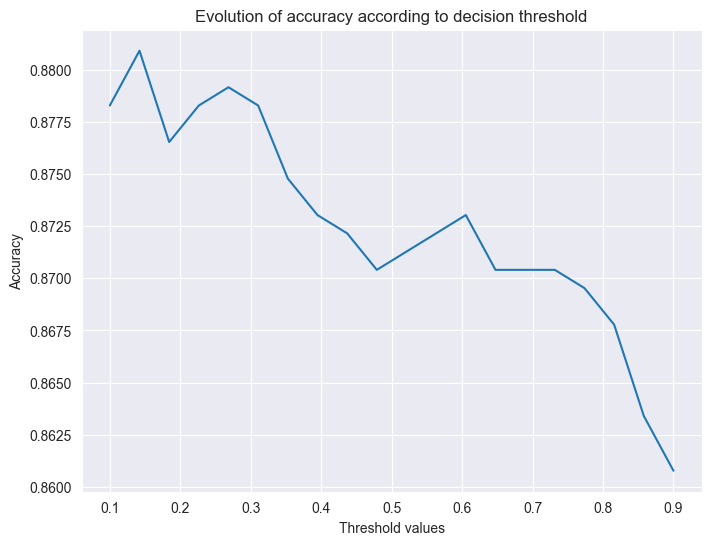

In [48]:
f = plt.figure(figsize=(8, 6))
plt.plot(thresholds, accuracies)
plt.title("Evolution of accuracy according to decision threshold")
plt.xlabel("Threshold values")
plt.ylabel("Accuracy")
plt.savefig("accuracy_threhsolds.png")

In [27]:
max_accuracy = np.max(accuracies)
best_treshold = thresholds[np.argmax(accuracies)]
print(f"Max accuracy : {max_accuracy}")
print(f"Best threshold : {best_treshold}")

Max accuracy : 0.8809106830122592
Best threshold : 0.14210526315789473


Opti threshold based on val loss :
* Max accuracy : 0.8537
* Best threshold : 0.4368

Opti threshold based on val acc :
* Max accuracy : 0.8809
* Best threshold : 0.1421

## Ensemble learning

In this part, we use a simple ensemble learning technique (Bagging) to combine the predictions of two base models (BERT and LSTM)

In [31]:
all_logits = torch.tensor([])

model.eval()
for i, batch in enumerate(tqdm(test_dataloader)):

  input_ids = batch[0].to(device)
  input_masks = batch[1].to(device)

  with torch.no_grad():
    result = model(input_ids, token_type_ids = None, attention_mask = input_masks, return_dict = True)

    logits = result.logits.detach().cpu()

    all_logits = torch.cat((all_logits, logits), dim = 0)


100%|██████████| 102/102 [00:59<00:00,  1.72it/s]


In [38]:
logits = pd.DataFrame(all_logits[:, 1].numpy(), columns=['logits'])
logits['prob'] = (logits['logits'] - logits['logits'].min()) / (logits['logits'].max() - logits['logits'].min())
logits.head()

,logits,prob
0,1.213986,0.819364
1,1.264310,0.835296
2,0.840177,0.701019
3,1.495502,0.908490
4,1.639140,0.953965


In [21]:
pred_lstm = pd.read_csv("./y_test.csv", header=None)
pred_lstm.head()

,0
0,0.777304
1,0.646756
2,0.833683
3,0.426565
4,0.969616


In [57]:
res = pd.merge(pred_lstm, logits, right_index=True, left_index=True)
res['average'] = (res[0] + res['prob'])/2
res['target'] = (res[0] * 0.2 + res['prob'] * 0.8) >= 0.7
res.drop(columns = [0, 'logits', 'prob', 'average'], axis = 1, inplace=True)
res = pd.merge(ids, res, left_index = True, right_index = True)
res.replace({True: 1, False: 0}, inplace=True)
res.to_csv("res_average.csv", sep = ",", index = False)
res.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


## Make a submission

In [14]:
test_data = pd.read_csv("test.csv")
print(f"Size of test set : {len(test_data)}")

Size of test set : 3263


In [15]:
input_ids = []
attention_masks = []

tweets = test_data['text'].to_list()

for tweet in tweets:
  output_dict = tokenizer.encode_plus(tweet, add_special_tokens=True, max_length=90, padding='max_length', return_attention_mask=True, return_tensors='pt')
  input_ids.append(output_dict.input_ids)
  attention_masks.append(output_dict.attention_mask)

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

In [16]:
from torch.utils.data import TensorDataset, random_split, DataLoader

dataset = TensorDataset(input_ids, attention_masks)

test_dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = False)

In [25]:
all_preds = torch.tensor([])
all_logits = torch.tensor([])

model.eval()
for i, batch in enumerate(tqdm(test_dataloader)):

  input_ids = batch[0].to(device)
  input_masks = batch[1].to(device)

  with torch.no_grad():
    result = model(input_ids, token_type_ids = None, attention_mask = input_masks, return_dict = True)

    logits = result.logits.detach().cpu()

    all_logits = torch.cat((all_logits, logits), dim = 0)

    preds = (logits[:, 1] >= 0.5).type(dtype=torch.int32)

    all_preds = torch.cat((all_preds, preds), dim = 0)

100%|██████████| 102/102 [00:58<00:00,  1.74it/s]


In [23]:
ids = test_data['id']
preds = pd.DataFrame(all_preds.numpy().astype(np.int32), columns = ['target'])
res = pd.merge(ids, preds, left_index = True, right_index = True)

In [24]:
res.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [27]:
res['target'].sum()

1051

In [39]:
res.to_csv("res_optih_acc_nothreshopti.csv", sep = ",", index = False)

To submit the res file :

In [ ]:
!kaggle competitions submit -c nlp-getting-started -f res.csv

# Results

## Metrics

\begin{table}[]
\begin{tabular}{|l|l|l|l|l|}
\hline
Model                     & Accuracy_on_test_set & Accuracy_on_train_set & F1_on_train_set & ROCAUC_on_train_set \\ \hline
Opti\_h, opti\_t (val)    & 0.84186              & 0.871                 & 0.83            & 0.854               \\ \hline
Opti\_h  (val)            & 0.84002              & 0.870                 & 0.827           & 0.852               \\ \hline
Opti\_h, opti\_t (acc)    & 0.84216              & 0.8809                & 0.855           & 0.8586               \\ \hline
Opti\_h (acc)             & 0.84216              & 0.872                 & 0.837           & 0.8586               \\ \hline
No\_opti                  & 0.844                & 0.890                 & ?               & ?                   \\ \hline
\end{tabular}
\end{table}

## Analysis of tweets wrongly classified

In [ ]:
all_preds, all_labels = get_preds(train_dataloader, model, device)

In [ ]:
wrong_preds = (all_preds != all_labels)

In [ ]:
wrong_preds = np.array(wrong_preds)

In [ ]:
wrong_tweets = data[wrong_preds]

In [ ]:
wrong_tweets['pred'] = (wrong_tweets['target'] + 1) % 2

In [ ]:
wrong_tweets

## Possible improvements

* To improve the model performance we could set a threshold that maximises the val accuracy rather than just using argmax, which is equivalent to threshold 50%
* Create an ensemble learning architecture
* Rather than optimizing the threshold for accuracy, we could do it for f1 score, recall or precision and see what we get
* Should try to optimize hyperparameters based on accuracy